In [2]:
%matplotlib inline
import GEOparse
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import decomposition
from sklego.linear_model import LowessRegression
from sklearn.feature_selection import f_classif
from sklearn.linear_model import LinearRegression
from sklearn.metrics import explained_variance_score, plot_roc_curve
import statsmodels.api as sm
from scipy.stats import ttest_ind
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from matplotlib.backends.backend_pgf import FigureCanvasPgf
matplotlib.backend_bases.register_backend('pdf', FigureCanvasPgf)


In [43]:
data = pd.read_csv("../Dataset/Abdollahi2019/data.csv", na_values=["#NULL!"])

In [46]:
table = data.iloc[:,1:5]

In [47]:
np.mean(table)

miRNA21     2.031042
miRNA638    0.144445
miRNA148    0.473948
miRNA152    0.029582
dtype: float64

In [48]:
def get_means_and_variances(table):
    return np.mean(table), np.var(table, ddof=1)

In [49]:
def mean_variance_plot(table):
    means, variances = get_means_and_variances(table)
    plt.scatter(means, variances)
    plt.xlabel("mean")
    plt.ylabel("variance")
    plt.plot()

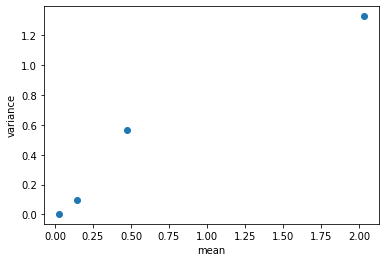

In [51]:
mean_variance_plot(table)

[]

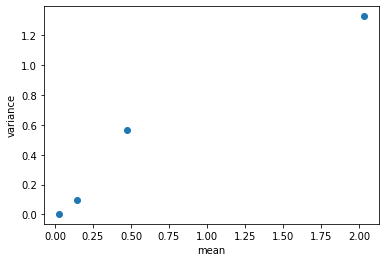

In [52]:
means, variances = get_means_and_variances(table)
plt.scatter(means, variances)
plt.xlabel("mean")
plt.ylabel("variance")
plt.plot()

### Trying log-transformation

In [53]:
log_table = table

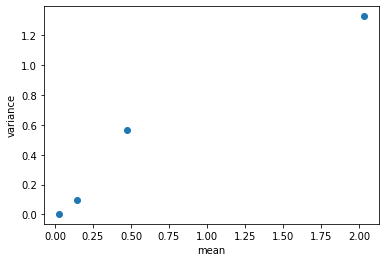

In [54]:
mean_variance_plot(log_table)

In [55]:
norm_log_table = log_table - np.mean(log_table)

In [56]:
norm_log_table /= np.sqrt(np.mean(np.var(norm_log_table, ddof=1)))

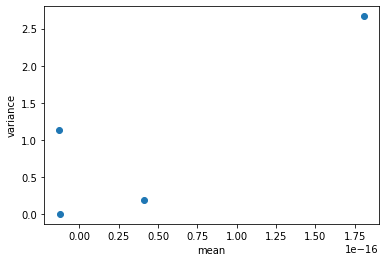

In [57]:
mean_variance_plot(norm_log_table)

### ANOVA

In [58]:
norm_log_table

,miRNA21,miRNA638,miRNA148,miRNA152
0,-0.982188,-0.188627,-0.287453,0.005961
1,-0.617556,-0.182210,0.756934,-0.038621
2,-1.144531,-0.185637,0.766596,0.215207
3,-0.701985,-0.178371,0.831632,-0.039557
4,-1.211252,-0.190355,0.787136,0.028421
...,...,...,...,...
81,-1.063359,-0.204620,-0.576440,-0.040366
82,-0.857953,-0.172818,-0.570943,-0.041450
83,0.241328,0.009569,-0.630341,-0.025629
84,1.222607,-0.204592,-0.444313,-0.039382


In [59]:
controls = data["group"] == 1

In [60]:
X = np.array(controls).reshape(-1, 1)

In [61]:
linreg = LinearRegression()
linreg.fit(X, norm_log_table)

LinearRegression()

In [62]:
fitted = linreg.predict(X)
explained_variance_score(norm_log_table, fitted, multioutput="variance_weighted")

0.26282819110179206

# PCA

In [63]:
pca = decomposition.PCA(n_components=2)

In [64]:
pca.fit(norm_log_table)

PCA(n_components=2)

In [65]:
components = pca.transform(norm_log_table)

In [66]:
components

array([[-8.27912084e-01, -5.92750478e-01],
       [-8.13262188e-01,  5.12366437e-01],
       [-1.31576827e+00,  3.55510952e-01],
       [-9.17051827e-01,  5.56326460e-01],
       [-1.38464222e+00,  3.51924309e-01],
       [-1.03440928e+00,  5.52400980e-01],
       [-7.76861893e-01,  4.04059951e-01],
       [-6.94596508e-01,  6.16348941e-01],
       [-1.95396001e+00,  4.50986221e+00],
       [-1.59988536e+00,  1.16978270e-01],
       [-1.40421341e+00, -1.17829517e+00],
       [-2.61456082e-01, -7.94586377e-01],
       [-5.69934622e-02, -7.32487782e-01],
       [ 1.91138486e-01, -6.33781074e-01],
       [-1.17088062e+00, -1.11164629e+00],
       [ 2.71724492e-01, -5.89665104e-01],
       [-2.55525329e+00,  2.89164350e+00],
       [-1.17083600e+00, -1.11215414e+00],
       [-1.64782647e+00,  1.68276913e-01],
       [-1.18576498e+00, -1.10895565e+00],
       [-1.29205241e-01, -4.43173007e-01],
       [-8.53831101e-01,  9.77590887e-01],
       [ 2.27514983e-01, -6.40909113e-01],
       [ 5.

In [67]:
sick = 1 - controls

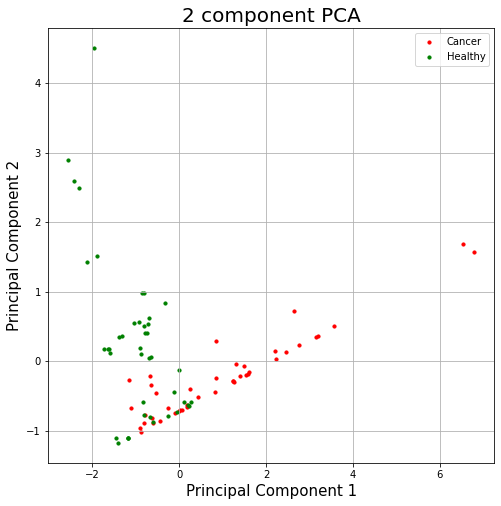

In [69]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)

ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Cancer', 'Healthy']
colors = ['r', 'g']
ax.scatter(components[controls == False, 0], components[controls == False, 1], c = 'r', s = 10)
ax.scatter(components[controls == True, 0], components[controls == True, 1], c = 'g', s = 10)
ax.legend(targets)
ax.grid()

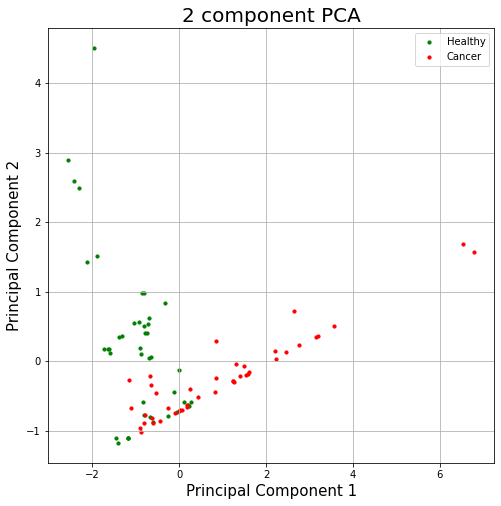

In [70]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)

ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Cancer', 'Healthy'][::-1]
colors = ['r', 'g']
ax.scatter(components[controls == True, 0], components[controls == True, 1], c = 'g', s = 10)
ax.scatter(components[controls == False, 0], components[controls == False, 1], c = 'r', s = 10)
ax.legend(targets)
ax.grid()

### Linear regression adjustments

In [71]:
covars = data.iloc[:,5:8]

In [72]:
covars

,Age,Livingplace,Smoker
0,66,2.000000,1.0
1,61,2.000000,1.0
2,68,1.000000,2.0
3,67,2.000000,1.0
4,66,1.000000,1.0
...,...,...,...
81,67,2.000000,2.0
82,64,2.000000,1.0
83,72,1.532468,1.0
84,71,2.000000,1.0


In [73]:
covars = covars.fillna(covars.mean())

In [74]:
linreg = LinearRegression()
linreg.fit(covars, norm_log_table)

LinearRegression()

In [75]:
adj_norm_log_table = norm_log_table - linreg.predict(covars)

# PCA

In [76]:
pca = decomposition.PCA(n_components=2)

In [77]:
pca.fit(adj_norm_log_table)

PCA(n_components=2)

In [78]:
components = pca.transform(adj_norm_log_table)

In [79]:
components

array([[-0.4099227 , -0.57784565],
       [ 0.4936335 ,  0.29550919],
       [-1.41590295,  0.35198191],
       [-0.5737948 ,  0.62085936],
       [-1.41284201,  0.60966865],
       [-0.79789043,  0.43558416],
       [-0.76782847,  0.54958654],
       [ 0.13597728,  0.52746378],
       [-0.74079772,  4.21001627],
       [-0.98989889,  0.18656172],
       [-0.062138  , -1.39048165],
       [-0.37760662, -0.62159087],
       [ 0.43782341, -1.07742763],
       [ 0.73776637, -0.69298029],
       [-1.19481684, -0.92848158],
       [ 0.75214312, -0.91687089],
       [-3.02634955,  3.39653823],
       [-0.86369371, -1.32429551],
       [-1.43938449,  0.10072751],
       [-1.32387545, -0.8632665 ],
       [ 0.46771318, -0.78015426],
       [-1.2856828 ,  1.26554594],
       [ 0.44432255, -0.59689647],
       [-0.09954851, -0.29869369],
       [-1.57844796,  1.60751232],
       [-1.37558844,  0.02895443],
       [-0.30743241,  0.66471486],
       [-0.15497262, -1.11051495],
       [-0.59849983,

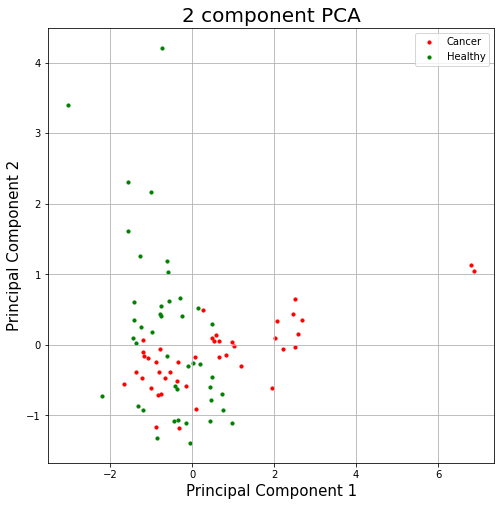

In [80]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)

ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Cancer', 'Healthy']
colors = ['r', 'g']
ax.scatter(components[controls == False, 0], components[controls == False, 1], c = 'r', s = 10)
ax.scatter(components[controls == True, 0], components[controls == True, 1], c = 'g', s = 10)
ax.legend(targets)
ax.grid()

### XGBoost

In [81]:
X_train, X_test, y_train, y_test = train_test_split(adj_norm_log_table, controls, test_size=0.33, random_state=42)

In [82]:
model = XGBClassifier(use_label_encoder=False)
model.fit(X_train, y_train)

[20:31:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=16,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

C:\Users\olefr\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


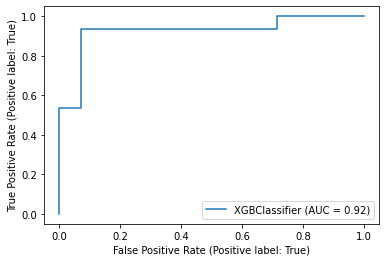

In [83]:
plot_roc_curve(model, X_test, y_test)

### Export data

In [93]:
mirnas = ["hsa-miR-21-5p", "hsa-miR-638", "hsa-miR-148a-3p", "hsa-miR-152-3p"]

In [94]:
from Scripts import converters

In [95]:
sequences = converters.canonical_to_seq(mirnas)

In [96]:
adj_norm_log_table.columns = sequences
adj_norm_log_table *= -1
adj_norm_log_table["cancer"] = sick
adj_norm_log_table.head()

,UAGCUUAUCAGACUGAUGUUGA,AGGGAUCGCGGGCGGGUGGCGGCCU,UCAGUGCACUACAGAACUUUGU,UCAGUGCAUGACAGAACUUGG,cancer
0,0.541799,0.079963,0.460290,-0.014714,0
1,-0.545245,0.185036,-0.165442,0.032333,0
2,1.302032,0.453728,-0.685106,-0.199471,0
3,0.406078,0.047409,-0.742526,0.030310,0
4,1.225039,0.117691,-0.936391,-0.030463,0


In [97]:
#norm_log_table.to_csv("../TransformedData/Asakura2020.csv", index=False)
adj_norm_log_table.to_csv("../TransformedData/Abdollahi2019.csv", index=False)